# Custom Dataset Analysis

Initialization - Set Runtime type as GPU

This Notebook is part of the final Thesis.

This consists of analysis and parsing of the custom dataset from Json file to Dataframe. 

The annotated custom dataset used in this study is created using the Annotation tool provided by Haystack from Deepest AI.

SQuAD type Questions answers are created using this tool from the domain context of Financial Literacy in India.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/huggingface/transformers
!cd /content/transformers && pip install . -q

Cloning into 'transformers'...
remote: Enumerating objects: 92329, done.
remote: Total 92329 (delta 0), reused 0 (delta 0), pack-reused 92329
Receiving objects: 100% (92329/92329), 76.63 MiB | 29.49 MiB/s, done.
Resolving deltas: 100% (66707/66707), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3 MB 8.7 MB/s 
     |████████████████████████████████| 895 kB 72.7 MB/s 
     |████████████████████████████████| 596 kB 34.4 MB/s 
     |████████████████████████████████| 61 kB 632

In [ ]:
!pip install datasets -q

     |████████████████████████████████| 298 kB 8.3 MB/s 
     |████████████████████████████████| 1.1 MB 47.5 MB/s 
     |████████████████████████████████| 243 kB 63.8 MB/s 
     |████████████████████████████████| 132 kB 74.4 MB/s 
     |████████████████████████████████| 160 kB 69.8 MB/s 
     |████████████████████████████████| 192 kB 72.2 MB/s 
     |████████████████████████████████| 271 kB 74.3 MB/s 


In [ ]:
# Make sure you have a GPU running
!nvidia-smi

Mon Dec 20 09:34:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import torch
import json
import sys
import time
import datetime
import random
import collections
import pprint
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

# Import from Transformers
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering
from transformers import BertForQuestionAnswering
from transformers import RobertaForQuestionAnswering
from transformers import Trainer, TrainingArguments

import datasets 
from datasets import load_dataset, load_metric, Dataset

# EDA For Custom Dataset

## Common Functions

In [ ]:
def squad_json_to_dataframe(input_file_path, record_path = ['data','paragraphs','qas','answers'],
                           verbose = 1):
    """
    input_file_path: path to the squad json file.
    record_path: path to deepest level in json file default value is
    ['data','paragraphs','qas','answers']
    verbose: 0 to suppress it default is 1
    """
    if verbose:
        print("Reading the json file")    
    file = json.loads(open(input_file_path).read())
    if verbose:
        print("processing...")
    # parsing different level's in the json file
    js = pd.io.json.json_normalize(file , record_path )
    m = pd.io.json.json_normalize(file, record_path[:-1] )
    r = pd.io.json.json_normalize(file,record_path[:-2])
    
    #combining it into single dataframe
    idx = np.repeat(r['context'].values, r.qas.str.len())
    ndx  = np.repeat(m['id'].values,m['answers'].str.len())
    m['context'] = idx
    js['q_idx'] = ndx
    main = pd.concat([ m[['id','question','context']].set_index('id'),js.set_index('q_idx')],1,sort=False).reset_index()
    main['c_id'] = main['context'].factorize()[0]
    if verbose:
        print("shape of the dataframe is {}".format(main.shape))
        print("Done")
    return main

In [ ]:
def parse_dataset(squad):
    # initialize list where we will place all of our data
    new_squad = []
    # we need to loop through groups -> paragraphs -> qa_pairs
    for group in squad['data']:
        for paragraph in group['paragraphs']:
            # we pull out the context from here
            context = paragraph['context']
            for qa_pair in paragraph['qas']:
                # we pull out the question
                question = qa_pair['question']
                # now the logic to check if we have 'answers' or 'plausible_answers'
                if 'answers' in qa_pair.keys() and len(qa_pair['answers']) > 0:
                    answer = qa_pair['answers'][0]['text']
                elif 'plausible_answers' in qa_pair.keys() and len(qa_pair['plausible_answers']) > 0:
                    answer = qa_pair['plausible_answers'][0]['text']
                else:
                    # this shouldn't happen, but just in case we just set answer = None
                    answer = None
                # append dictionary sample to parsed squad
                new_squad.append({
                    'question': question,
                    'answer': answer,
                    'context': context
                })
    return new_squad                

In [ ]:
### Get the counts for each Question Type

# Function to get the questions' head
def get_ques_type(question: str) -> str:
    return question.split()[0].strip().lower()

def get_ques_type_cnt(df):
    df_ques_type=pd.DataFrame()
    df_ques_type['question'] = df['question'].apply(get_ques_type)
    total = df_ques_type.shape[0]
    print (total)
    top_qheads = df_ques_type['question'].value_counts().sort_values(ascending=False)[0:25]
    qheads = list(top_qheads.index)
    count = top_qheads.to_list()
    print("Label\t\tCount\t\tPercentage\n")
    for i, j in enumerate(top_qheads):
      print("{: <15} {: <15} {:.1f}%".format(qheads[i],j,j/total*100))
    print (qheads)
    #df_ques_type['question'].value_counts().sort_values(ascending=False)[0:10].plot.barh()
    df_ques_type['question'].value_counts().sort_values(ascending=False)[0:10].plot.bar()

In [ ]:
def print_squad_sample(df: pd.core.frame.DataFrame, line_length: int=20, separator_length: int=120) -> None:
    sample = df.iloc[sample_index]
    context = sample.context.split()
    print('CONTEXT: ')
    lines = [' '.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
    for l in lines:
        print(l)
    print('='*separator_length)
    questions = df[df.context.values==sample.context]
    max_len = len(max(questions.question, key=len)) + 5
    print("{: <{max_len}} {: <{max_len}}".format('QUESTION:','ANSWER:', max_len=max_len))
    for idx, row in questions.iterrows():
        question = row.question
        answer = row.answer
        print("{: <{max_len}} {: <{max_len}}".format(question,answer, max_len=max_len))

## Get Dataset

In [ ]:
# Train documents
import json
with open('/content/drive/MyDrive/FinLitQA/flitqa/finlitqa_1220.json', 'r') as f:
    flitqa = json.load(f)
    
input_file_path = '/content/drive/MyDrive/FinLitQA/flitqa/finlitqa_1220.json'
record_path = ['data','paragraphs','qas','answers']
df_flitqa = squad_json_to_dataframe(input_file_path=input_file_path,record_path=record_path)
df_flitqa.head(2)

Reading the json file
processing...
shape of the dataframe is (1102, 10)
Done


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,index,question,context,answer_id,document_id,question_id,text,answer_start,answer_category,c_id
0,209552,How does a PMEGP work?,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGR...,267737,394107,209552,the beneficiary has to invest only 5-10% of th...,284,None,0
1,209854,What is CGTMSE scheme?,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGR...,268055,394107,209854,The CGTMSE provides a collateral guarantee for...,1133,None,0


## Visualize

In [ ]:
df_flitqa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            1096 non-null   int64 
 1   question         1096 non-null   object
 2   context          1096 non-null   object
 3   answer_id        1096 non-null   int64 
 4   document_id      1096 non-null   int64 
 5   question_id      1096 non-null   int64 
 6   text             1096 non-null   object
 7   answer_start     1096 non-null   int64 
 8   answer_category  0 non-null      object
 9   c_id             1096 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 85.8+ KB


                                            question  ...                                            context
0              Is savings account a deposit account?  ...  5.SAVINGS_SALARY_NRI _ACCOUNT\n\nA savings ban...
1  What is the account called where salaries of e...  ...  5.SAVINGS_SALARY_NRI _ACCOUNT\n\nA savings ban...
2  On what basis is the interest credited in a sa...  ...  5.SAVINGS_SALARY_NRI _ACCOUNT\n\nA savings ban...
3  What is the range of savings account interest ...  ...  5.SAVINGS_SALARY_NRI _ACCOUNT\n\nA savings ban...
4   How much money is guaranteed in a bank in India?  ...  5.SAVINGS_SALARY_NRI _ACCOUNT\n\nA savings ban...

[5 rows x 3 columns]
1096
Label		Count		Percentage

what            403             36.8%
how             198             18.1%
which           108             9.9%
is              78              7.1%
who             73              6.7%
why             51              4.7%
when            34              3.1%
can             29              

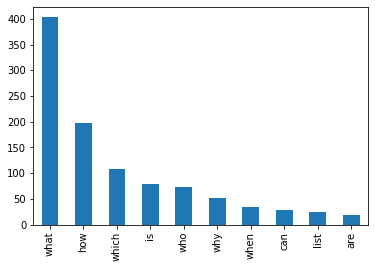

In [ ]:
# Parse the file Get question,context and answer
new_flitqa = parse_dataset(flitqa)

# Save the parsed validation file to Drive
import os
with open(os.path.join('/content/drive/MyDrive/FinLitQA/flitqa/', 'new_flitqa.json'), 'w') as f:
    json.dump(new_flitqa, f)

df_new_flitqa = pd.DataFrame.from_dict(pd.json_normalize(new_flitqa), orient='columns')
print (df_new_flitqa.head())
get_ques_type_cnt(df_new_flitqa)

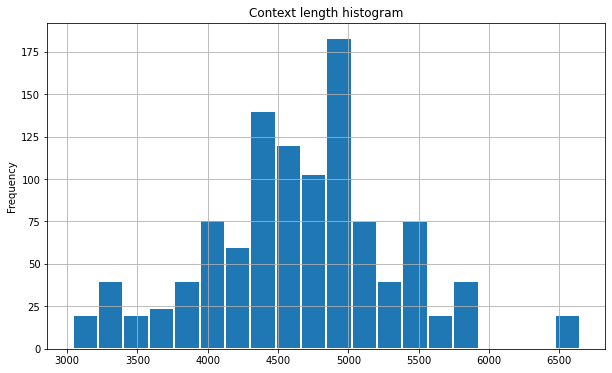

In [ ]:
figsize = (10,6)
# context length histogram
df_new_flitqa['context'].apply(len).plot.hist(title="Context length histogram",
                                    bins=20, edgecolor='white', linewidth=2,
                                    figsize=figsize, grid=True)

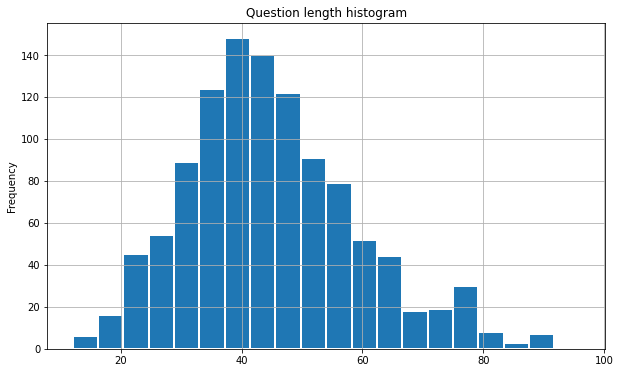

In [ ]:
# question length histogram
df_new_flitqa['question'].apply(len).plot.hist(title="Question length histogram", 
                                    bins = 20, edgecolor='white', linewidth=2, 
                                    figsize=figsize, grid=True)

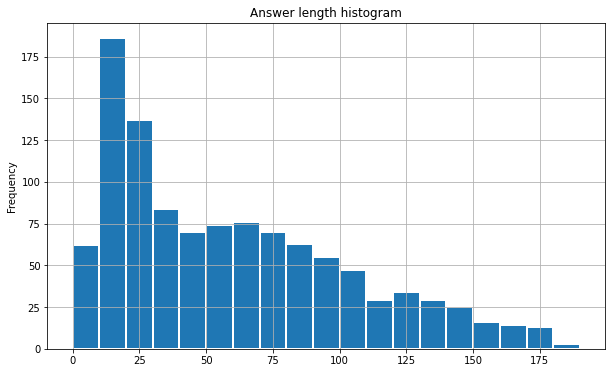

In [ ]:
# answer length histogram
df_new_flitqa['answer'].apply(len).plot.hist(title="Answer length histogram", 
                                  bins= range(0,200,10), edgecolor='white', linewidth=2,
                                  figsize=figsize, grid=True)

In [ ]:
#@title Show Samples { run: "auto", display-mode: "form" }
sample_index = 229 #@param {type:"slider", min:0, max:1000, step:1}
print_squad_sample(df_new_flitqa)

CONTEXT: 
10. HOME_LOAN Home loan is a secured loan offered by Banks, NBFCs and HFCs to help you buy a residential
property. In this, the property you are buying is mortgaged to the lender as security till the full repayment of
the home loan. Currently, home loan interest rate starts as low as 6.40% per annum. Lenders usually sanction 75% to
90% of the property value as loan, which can be repaid in EMIs over flexible tenure usually up to 30
years. Home Purchase Loan is the most common type of home loan availed usually to buy ready-to-move-in properties, under construction
properties and pre-owned homes/resale properties. As per RBI guidelines, lenders can offer loan-to-value (LTV) ratio of up to 75-90% of
the property value. Composite Loan is a perfect financing solution for individuals who want to buy a plot of land
either for investment or for building a house. In this type of home loan, the first disbursement is made towards
the purchase of a plot. The subsequent payments depend on 

# Format Dataframe

In [ ]:
df_flitqads = pd.DataFrame()

selected_columns = df_flitqa[["index","question","context","text","answer_start"]]
df_flitqads = selected_columns.copy()


df_flitqads['text'] = df_flitqads['text'].map(lambda t: [t])
df_flitqads['answer_start'] = df_flitqads['answer_start'].map(lambda t: [t])

df_flitqa_csv = df_flitqads.copy()

columns = ['text', 'answer_start']
df_flitqads['answers'] = df_flitqads[columns].to_dict(orient='records')
df_flitqads = df_flitqads.drop(columns=columns)
df_flitqads = df_flitqads.rename(columns={'index': 'id'})
df_flitqads['title'] = df_flitqads['context'].map(lambda s: str(s).split('\n', 1)[0])
df_flitqads = df_flitqads[['id', 'title', 'context', 'question', 'answers']]
df_flitqads.head()

,id,title,context,question,answers
0,209552,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGRAM,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGR...,How does a PMEGP work?,{'text': ['the beneficiary has to invest only ...
1,209854,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGRAM,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGR...,What is CGTMSE scheme?,{'text': ['The CGTMSE provides a collateral gu...
2,209561,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGRAM,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGR...,What is the subsidy rate for general category ...,{'text': ['The rate of subsidy will be 15% for...
3,209852,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGRAM,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGR...,What is the subsidy rate for special category ...,{'text': ['the subsidy from the government wil...
4,209853,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGRAM,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGR...,Is collateral required for PMEGP loan?,{'text': ['collateral is not required for proj...


In [ ]:
df_flitqa_csv = df_flitqa_csv.drop(columns=['index'])
df_flitqa_csv = df_flitqa_csv.rename(columns={'text': 'answers.text', 'answer_start': 'answers.answer_start'})

df_flitqa_csv.to_csv('/content/drive/MyDrive/FinLitQA/Finlitqa.csv', index=False)
df_flitqa_csv.head(2)

,question,context,answers.text,answers.answer_start
0,How does a PMEGP work?,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGR...,[the beneficiary has to invest only 5-10% of t...,[284]
1,What is CGTMSE scheme?,20. PRIME_MINISTERS_EMPLOYMENT_GUARANTEE PROGR...,[The CGTMSE provides a collateral guarantee fo...,[1133]


# Prepare Train Test data

In [ ]:
# Split Train test dataset
from sklearn.model_selection  import train_test_split
df_train, df_val = train_test_split(df_flitqads, test_size=0.2, random_state=102)



# Create Huggingface datsets from dataframes
flitqads_train = Dataset.from_pandas(df_train)
flitqads_val = Dataset.from_pandas(df_val)

# # Save the parsed validation file to Drive
# import os
# with open(os.path.join('/content/drive/MyDrive/FinLitQA/flitqa/', 'flitqa_train.json'), 'w') as f:
#     json.dump(flitqads_train.to_json(), f)

# import os
# with open(os.path.join('/content/drive/MyDrive/FinLitQA/flitqa/', 'flitqa_test.json'), 'w') as f:
#     json.dump(flitqads_val.to_json(), f)

flitqads_train.to_json("/content/drive/MyDrive/FinLitQA/flitqa/finlitqa_train.json")
flitqads_val.to_json("/content/drive/MyDrive/FinLitQA/flitqa/finlitqa_val.json")


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1090968

In [ ]:
flitqads_train, flitqads_val

(Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', '__index_level_0__'],
     num_rows: 876
 }), Dataset({
     features: ['id', 'title', 'context', 'question', 'answers', '__index_level_0__'],
     num_rows: 220
 }))